In [121]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [122]:
train = pd.read_csv('../data/train-parking.csv', parse_dates=[[3,4]], infer_datetime_format=True)
test=pd.read_csv('../data/test-no-label-parking.csv', parse_dates=[[3,4]], infer_datetime_format=True)
# valid_dow = pd.read_csv('../data/valid_dow.csv', infer_datetime_format=True, index_col='index').set_index('index.1')
# valid_hg = pd.read_csv('../data/valid_hg.csv', infer_datetime_format=True, index_col='index').set_index('index.1')
valid_swhg = pd.read_csv('../data/valid_swhg.csv', infer_datetime_format=True, index_col='index').set_index('index.1')

In [3]:
train.head()

,Date_Time,Street,From,To,Real.Spots,Street.Length,any_spot
0,2014-01-07 16:19:00,Mission Street,25th Street,26th Street,4,179.132970,1
1,2014-01-18 20:42:00,Polk Street,Ellis Street,Olive Street,0,52.740210,0
2,2014-01-18 20:39:00,Van Ness Avenue,Geary Boulevard,Myrtle Street,0,52.517840,0
3,2014-01-18 20:38:00,Van Ness Avenue,Bush Street,Fern Street,0,52.405315,0
4,2014-01-18 20:38:00,Van Ness Avenue,Daniel Burnham Court,Post Street,0,52.191193,0


##### Get the proper train and validation set

In [4]:
# train_dow = train[~train.index.isin(valid_dow.index)]
# train_hg = train[~train.index.isin(valid_hg.index)]
train_swhg = train[~train.index.isin(valid_swhg.index)]

## Select validation set - round 1

In [5]:
# get long and lat for train street
st_latlng = pd.read_csv("../data/train_longlat.csv", index_col = False,  dtype = {'lat':np.float64,'lng':np.float64})

In [6]:
train_swhg = pd.merge(train_swhg,st_latlng,how ='left',left_on=["Street","From","To"], right_on=["Street","From","To"])
valid_swhg= pd.merge(valid_swhg,st_latlng,how ='left',left_on=["Street","From","To"], right_on=["Street","From","To"])

In [7]:
# sensor related data
sensor = pd.read_csv('../data/aggregated_sensor.csv')

In [8]:
sensor['TIME_OF_DAY'] = sensor['TIME_OF_DAY']/100
sensor['TIME_OF_DAY'] = sensor['TIME_OF_DAY'].astype('int')

In [9]:
valid_swhg.head()

,Date_Time,Street,From,To,Real.Spots,Street.Length,any_spot,lat,lng
0,2014-01-21 17:35:00,23rd Street,Mission Street,Bartlett Street,1,96.037110,1,37.753846,-122.418619
1,2014-02-15 16:50:00,23rd Street,South Van Ness Avenue,Capp Street,1,96.301300,1,37.753976,-122.416441
2,2014-03-01 16:59:00,23rd Street,Mission Street,Bartlett Street,3,96.037110,1,37.753846,-122.418619
3,2014-03-15 08:15:00,Battery Street,Halleck Street,California Street,0,54.143090,0,37.793702,-122.400085
4,2014-02-24 11:10:00,Battery Street,California Street,Pine Street,0,107.501144,0,37.793224,-122.399989


In [10]:
# Clustering
from sklearn.cluster import KMeans
spots = np.vstack(train_swhg[['lat','lng']].values)
kmeans = KMeans().fit(spots)
train_swhg['street_cluster'] = kmeans.predict(train_swhg[['lat', 'lng']])
valid_swhg['street_cluster'] = kmeans.predict(valid_swhg[['lat', 'lng']])

In [11]:
# Time features
train_swhg['Minute'] = train_swhg.Date_Time.dt.minute
valid_swhg['Minute'] = pd.to_datetime(valid_swhg['Date_Time']).dt.minute
train_swhg['Hour'] = train_swhg.Date_Time.dt.hour
valid_swhg['Hour'] = pd.to_datetime(valid_swhg['Date_Time']).dt.hour
train_swhg['Dow'] = train_swhg.Date_Time.dt.weekday
valid_swhg['Dow'] = pd.to_datetime(valid_swhg['Date_Time']).dt.weekday

In [12]:
# Convert the time (Hour, Minute) to a numerical value XXXX
train_swhg['Time'] = train_swhg["Hour"]*100 + train_swhg['Minute']
valid_swhg['Time'] = valid_swhg["Hour"]*100 + valid_swhg['Minute']

In [13]:
def day_type(x):
    if x == 6 or x == 0:
        return 1
    else:
        return 0
    
train_swhg['isweekend'] = train_swhg['Dow'].apply(day_type)
valid_swhg['isweekend'] = valid_swhg['Dow'].apply(day_type)

In [14]:
# Single mean encoding target
from sklearn.model_selection import KFold

def multi_reg_mean_encoding(train, cols, splits =5):
    kf = KFold(n_splits = splits)
    global_mean = train.any_spot.mean()
    
    for col in cols:
        means = train.groupby(col).any_spot.mean()
        train[col+'_mean_enc'] = train[col].map(means)        
        for tr_ind,val_ind in kf.split(train):
            tr,val = train.iloc[tr_ind],train.iloc[val_ind]
            foldmeans = tr.groupby(col).any_spot.mean()
            train.loc[val_ind,col+"_mean_enc"] = train.loc[val_ind,col].map(foldmeans)    
        train[col+"_mean_enc"].fillna(global_mean,inplace=True)   
        
#mean encoding for validation and test data
def multi_test_mean_encoding(test, train, cols):
    for col in cols:
        global_mean = train.any_spot.mean()
        means = train.groupby(col).any_spot.mean()
        test[col+"_mean_enc"] = test[col].map(means)
        test[col+"_mean_enc"].fillna(global_mean, inplace=True)

In [15]:
# Single mean encoding real.spots

def realspot_mean_encoding(train, cols, splits =5):
    kf = KFold(n_splits = splits)
    global_mean = train['Real.Spots'].mean()
    
    for col in cols:
        means = train.groupby(col)['Real.Spots'].mean()
        train[col+'_realspot_enc'] = train[col].map(means)        
        for tr_ind,val_ind in kf.split(train):
            tr,val = train.iloc[tr_ind],train.iloc[val_ind]
            foldmeans = tr.groupby(col)['Real.Spots'].mean()
            train.loc[val_ind,col+"_realspot_enc"] = train.loc[val_ind,col].map(foldmeans)    
        train[col+"_realspot_enc"].fillna(global_mean,inplace=True)   
        
#mean encoding for validation and test data
def realspot_test_mean_encoding(test, train, cols):
    for col in cols:
        global_mean = train['Real.Spots'].mean()
        means = train.groupby(col)['Real.Spots'].mean()
        test[col+"_realspot_enc"] = test[col].map(means)
        test[col+"_realspot_enc"].fillna(global_mean, inplace=True)

In [16]:
#create a column for From_To pair
train_swhg['From_To'] = train_swhg['From'] + '_' + train_swhg['To']
valid_swhg['From_To'] = valid_swhg['From'] + '_' + valid_swhg['To']

In [17]:
cols = ['Dow','isweekend','From_To','Street','Hour', 'street_cluster' ]
multi_reg_mean_encoding(train_swhg, cols, splits =5)
multi_test_mean_encoding(valid_swhg, train_swhg, cols)

In [18]:
# Double variable mean encoding
colpairs = [('street_cluster','Dow'),('Dow','Hour'), ('street_cluster','Hour'),
            ('street_cluster','isweekend'),('From_To','Dow'),('From_To','Hour')]
pairlist = []
for pair in colpairs:
    colname = pair[0] + '_' + pair[1]
    pairlist.append(colname)
    train_swhg[colname] = list(zip(train_swhg[pair[0]], train_swhg[pair[1]]))
    valid_swhg[colname] = list(zip(valid_swhg[pair[0]], valid_swhg[pair[1]]))

In [19]:
multi_reg_mean_encoding(train_swhg, pairlist, splits =5)
multi_test_mean_encoding(valid_swhg, train_swhg, pairlist)

In [20]:
pairlist2= ['Street','From_To','street_cluster_Hour','street_cluster_isweekend','From_To_Dow','From_To_Hour']
realspot_mean_encoding(train_swhg, pairlist2, splits =5)
realspot_test_mean_encoding(valid_swhg, train_swhg, pairlist2)

In [21]:
#drop Data_Time, Real.Spots, street_cluster_Dow, Dow_Hour, street_cluster_Hour, street_cluster_isweekend, From_To_Dow, From_To_Hour
train_swhg = train_swhg.drop(['Date_Time','Real.Spots', 'street_cluster_Dow', 'Dow_Hour', 'street_cluster_Hour', 'street_cluster_isweekend', 'From_To_Dow', 'From_To_Hour'], axis =1)
valid_swhg = valid_swhg.drop(['Date_Time', 'Real.Spots', 'street_cluster_Dow', 'Dow_Hour', 'street_cluster_Hour', 'street_cluster_isweekend', 'From_To_Dow', 'From_To_Hour'], axis = 1)

In [22]:
train_swhg['Street'] = train_swhg.Street.str.lower()
train_swhg['From'] = train_swhg.From.str.lower()
train_swhg['To'] = train_swhg.To.str.lower()
valid_swhg['Street'] = valid_swhg.Street.str.lower()
valid_swhg['From'] = valid_swhg.From.str.lower()
valid_swhg['To'] = valid_swhg.To.str.lower()

In [23]:
# Join sensor data:
train_swhg = pd.merge(train_swhg,sensor, how='left',left_on=['Street','Dow','Hour'], right_on=['STREET_NAME','DOW','TIME_OF_DAY'])
valid_swhg = pd.merge(valid_swhg,sensor, how='left',left_on=['Street','Dow','Hour'], right_on=['STREET_NAME','DOW','TIME_OF_DAY'])

train_swhg = train_swhg.drop(['STREET_NAME','DOW','TIME_OF_DAY'],axis =1)
valid_swhg = valid_swhg.drop(['STREET_NAME','DOW','TIME_OF_DAY'],axis =1)

In [24]:
# convert categorical variables to code
def process_dfs(train_df, test_df, cols):
    # transfer categorical 
    for name in cols:
        train_df[name]=train_df[name].astype('category').cat.as_ordered()
        test_df[name] = pd.Categorical(test_df[name], categories=train_df[name].cat.categories, ordered=True)
    return train_df, test_df
  
def cat2code(train_df, test_df, cols):
    # transfer categorical 
    for name in cols:
        train_df[name]= train_df[name].cat.codes
        test_df[name] = test_df[name].cat.codes
    return train_df, test_df

In [25]:
catcols = ['Street','From','To', 'From_To']
train_swhg,valid_swhg = process_dfs(train_swhg.copy(),valid_swhg.copy(),catcols)
train_swhg,valid_swhg = cat2code(train_swhg,valid_swhg,catcols)

In [26]:
# split X and y
def split_response(df, response):
    y = df[response].values
    df.drop([response],axis=1,inplace=True)
    return df,y

In [27]:
X_train_swhg,y_train_swhg = split_response(train_swhg.copy(),'any_spot')
X_valid_swhg,y_valid_swhg = split_response(valid_swhg.copy(),'any_spot')

In [29]:
def f05_score_soft(labels, preds):
    tp = np.sum((labels==(preds>0.5)) & (labels==1))
    tn = np.sum((labels==(preds<0.5)) & (labels==0))
    fp = np.sum((preds>0.5))-tp
    fn = np.sum(preds<0.5)-tn
    p = tp/(tp+fp)
    r = tp/(tp+fn)
    score = 1.25*p*r/(0.25*p+r)
    return score

def f05_score_hard(labels, preds):
    tp = np.sum((labels==preds) & (labels==1))
    tn = np.sum((labels==preds) & (labels==0))
    fp = np.sum(preds==1)-tp
    fn = np.sum(preds==0)-tn
#    print(tp, tn, fp, fn)
    p = tp*1.0/(tp+fp)
    r = tp*1.0/(tp+fn)
    score = 1.25*p*r/(0.25*p+r)
    return score

In [30]:
# Manual gridsearch using validation set
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score
import itertools

n_estimators = [20, 30, 50]
max_depth = [3,5,10,15,20,25,30]
max_features = [0.2,0.4,0.5,0.6,0.8,0.9,1]
weight = [0.7, 0.85, 0.9, 1, 1.1, 1.25, 1.3, 1.4, 1.5]
para_lists = [n_estimators, max_depth, max_features, weight]
combo = list(itertools.product(*para_lists))

In [31]:
parameters = []
f05 = []
precision = []
recall = []

for p in combo:
    np.random.seed(1)
    m = RandomForestClassifier(n_estimators = p[0], max_depth =p[1], max_features=p[2],class_weight={0:1,1:p[3]}, min_samples_split = 2, n_jobs=-1)
    m.fit(X_train_swhg,y_train_swhg)
    pred = m.predict(X_valid_swhg)
    prec = precision_score(y_valid_swhg, pred)
    rec = recall_score(y_valid_swhg, pred)
    f = f05_score_hard(y_valid_swhg, pred)
    parameters.append(p)
    f05.append(f)
    precision.append(prec)
    recall.append(rec)

table3 = pd.DataFrame({'Parameters': parameters, 'f0.5': f05, 'precision':precision, 'recall':recall})

In [32]:
table3.sort_values('f0.5', ascending=False, inplace=True)

In [33]:
table3.head()

,Parameters,f0.5,precision,recall
188,"(20, 10, 1, 1.5)",0.581395,0.666667,0.384615
264,"(20, 20, 0.4, 1)",0.581395,0.666667,0.384615
154,"(20, 10, 0.6, 0.85)",0.576923,0.692308,0.346154
366,"(20, 25, 0.9, 1.3)",0.574324,0.708333,0.326923
429,"(20, 30, 0.9, 1.3)",0.574324,0.708333,0.326923


In [107]:
# use the best hyperparameters (80, 25, 1, 0.9) to get feature importance:
#(20,15,1,1.2)42
#(20,10,1,1.1)1
#(20,25,0.9,1.4)1
best = (20, 20, 0.4, 1)
np.random.seed(1)
m2 = RandomForestClassifier(n_estimators = best[0], max_depth =best[1], max_features=best[2], class_weight={0:1,1:best[3]}, min_samples_split = 2, n_jobs=-1)
m2.fit(X_train_swhg,y_train_swhg)

feat_imp_swhg = pd.DataFrame({
    'features': X_train_swhg.columns,
    'imp' :m2.feature_importances_
})
feat_imp_swhg.sort_values(by='imp', inplace=True, ascending=False)

In [108]:
pred = m2.predict(X_valid_swhg)
prec = precision_score(y_valid_swhg, pred)
rec = recall_score(y_valid_swhg, pred)
f = f05_score_hard(y_valid_swhg, pred)
print (f)

0.581395348837


In [109]:
from sklearn.metrics import log_loss
log_loss(y_valid_swhg,pred)

9.2989525933368622

In [56]:
feat_imp_swhg

,features,imp
15,From_To_mean_enc,0.070336
26,From_To_realspot_enc,0.066627
10,Time,0.049825
7,Minute,0.048514
3,Street.Length,0.045516
20,Dow_Hour_mean_enc,0.037350
31,TOTAL_OCCUPIED_TIME_pct,0.034354
5,lng,0.025839
29,From_To_Dow_realspot_enc,0.025020
2,To,0.024090


In [58]:
to_drop_swhg = feat_imp_swhg[feat_imp_swhg['imp'] <= 0.015].features

### Dropping Highly Correlated Features

In [59]:
import scipy
from scipy.cluster import hierarchy as hc
import matplotlib.pyplot as plt

In [60]:
to_keep = feat_imp_swhg[feat_imp_swhg>0.015].features
df_keep = X_train_swhg[to_keep].copy()

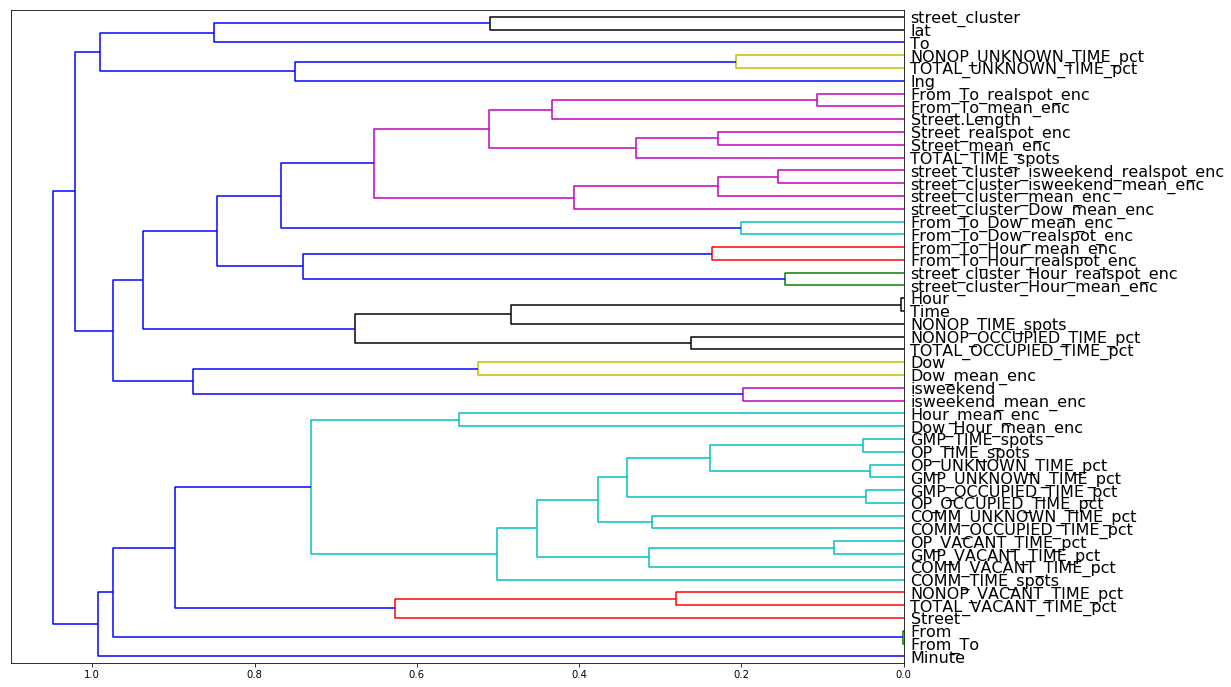

In [61]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,12))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [62]:
df_keep.columns

Index(['From_To_mean_enc', 'From_To_realspot_enc', 'Time', 'Minute',
       'Street.Length', 'Dow_Hour_mean_enc', 'TOTAL_OCCUPIED_TIME_pct', 'lng',
       'From_To_Dow_realspot_enc', 'To', 'From_To', 'NONOP_OCCUPIED_TIME_pct',
       'lat', 'street_cluster_Hour_mean_enc', 'street_cluster_Dow_mean_enc',
       'TOTAL_VACANT_TIME_pct', 'street_cluster_isweekend_mean_enc',
       'GMP_VACANT_TIME_pct', 'Hour_mean_enc', 'Street_mean_enc',
       'TOTAL_UNKNOWN_TIME_pct', 'From', 'NONOP_VACANT_TIME_pct',
       'Dow_mean_enc', 'From_To_Dow_mean_enc',
       'street_cluster_Hour_realspot_enc', 'COMM_OCCUPIED_TIME_pct',
       'NONOP_UNKNOWN_TIME_pct', 'GMP_UNKNOWN_TIME_pct',
       'OP_OCCUPIED_TIME_pct', 'street_cluster_mean_enc',
       'From_To_Hour_realspot_enc', 'OP_UNKNOWN_TIME_pct',
       'From_To_Hour_mean_enc', 'Dow', 'street_cluster_isweekend_realspot_enc',
       'GMP_OCCUPIED_TIME_pct', 'Hour', 'COMM_UNKNOWN_TIME_pct',
       'COMM_VACANT_TIME_pct', 'TOTAL_TIME_spots', 'NONOP_TI

In [63]:
def get_oob(df):
    np.random.seed(42)
    m = RandomForestClassifier(n_estimators = 20, max_depth =20, max_features=0.9, class_weight={0:1,1:1.4}, min_samples_split = 2, n_jobs=-1,oob_score=True)
    m.fit(df, y_train_swhg)
    return m.oob_score_

In [64]:
get_oob(df_keep)

0.70550847457627119

In [65]:
for c in ('GMP_TIME_spots','Street_realspot_enc','GMP_UNKNOWN_TIME_pct','NONOP_OCCUPIED_TIME_pct','GMP_VACANT_TIME_pct','Hour','From','Minute'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

GMP_TIME_spots 0.703389830508
Street_realspot_enc 0.705508474576
GMP_UNKNOWN_TIME_pct 0.712923728814
NONOP_OCCUPIED_TIME_pct 0.707627118644
GMP_VACANT_TIME_pct 0.720338983051
Hour 0.700211864407
From 0.702330508475
Minute 0.705508474576


In [66]:
#'GMP_TIME_spots','Street_realspot_enc','GMP_UNKNOWN_TIME_pct','NONOP_OCCUPIED_TIME_pct','GMP_VACANT_TIME_pct','Hour','From','Minute'
droplist = ['GMP_TIME_spots','Street_realspot_enc','GMP_UNKNOWN_TIME_pct','NONOP_OCCUPIED_TIME_pct','GMP_VACANT_TIME_pct','Hour','From','Minute']

### Rerun Grid Search to find parameters after dropping features

In [67]:
finalkeep = df_keep.drop(droplist, axis = 1)

In [68]:
finalval = X_valid_swhg[finalkeep.columns]

In [71]:
parameters = []
f05 = []
precision = []
recall = []

for p in combo:
    np.random.seed(1)
    m = RandomForestClassifier(n_estimators = p[0], max_depth =p[1], max_features=p[2],class_weight={0:1,1:p[3]}, min_samples_split = 2, n_jobs=-1)
    m.fit(finalkeep,y_train_swhg)
    pred = m.predict(finalval)
    prec = precision_score(y_valid_swhg, pred)
    rec = recall_score(y_valid_swhg, pred)
    f = f05_score_hard(y_valid_swhg, pred)
    parameters.append(p)
    f05.append(f)
    precision.append(prec)
    recall.append(rec)

table4 = pd.DataFrame({'Parameters': parameters, 'f0.5': f05, 'precision':precision, 'recall':recall})

In [72]:
table4.sort_values('f0.5', ascending=False, inplace=True)
table4.head()

,Parameters,f0.5,precision,recall
1067,"(60, 10, 1, 1.25)",0.609756,0.714286,0.384615
1508,"(80, 10, 1, 1.25)",0.593750,0.703704,0.365385
203,"(20, 15, 0.4, 1.25)",0.570652,0.636364,0.403846
791,"(40, 25, 0.6, 1.5)",0.568182,0.645161,0.384615
854,"(40, 30, 0.6, 1.5)",0.568182,0.645161,0.384615


In [73]:
finalfeatures = finalkeep.columns

### DOW-retrain entire model - remember to drop insignificant columns in the end

In [123]:
train = pd.merge(train,st_latlng,how ='left',left_on=["Street","From","To"], right_on=["Street","From","To"])
test= pd.merge(test,st_latlng,how ='left',left_on=["Street","From","To"], right_on=["Street","From","To"])

spots = np.vstack(train[['lat','lng']].values)
kmeans = KMeans().fit(spots)
train['street_cluster'] = kmeans.predict(train[['lat', 'lng']])
test['street_cluster'] = kmeans.predict(test[['lat', 'lng']])

In [124]:
train['Minute'] = train.Date_Time.dt.minute
test['Minute'] = pd.to_datetime(test['Date_Time']).dt.minute
train['Hour'] = train.Date_Time.dt.hour
test['Hour'] = pd.to_datetime(test['Date_Time']).dt.hour
train['Dow'] = train.Date_Time.dt.weekday
test['Dow'] = pd.to_datetime(test['Date_Time']).dt.weekday

In [125]:
train['Time'] = train["Hour"]*100 + train['Minute']
test['Time'] = test["Hour"]*100 + test['Minute']
train['isweekend'] = train['Dow'].apply(day_type)
test['isweekend'] = test['Dow'].apply(day_type)
train['From_To'] = train['From'] + '_' + train['To']
test['From_To'] = test['From'] + '_' + test['To']

In [126]:
cols = ['Dow','isweekend','From_To','Street','Hour', 'street_cluster' ]
multi_reg_mean_encoding(train, cols, splits =5)
multi_test_mean_encoding(test, train, cols)

In [127]:
colpairs = [('street_cluster','Dow'),('Dow','Hour'), ('street_cluster','Hour'),
            ('street_cluster','isweekend'),('From_To','Dow'),('From_To','Hour')]
pairlist = []
for pair in colpairs:
    colname = pair[0] + '_' + pair[1]
    pairlist.append(colname)
    train[colname] = list(zip(train[pair[0]], train[pair[1]]))
    test[colname] = list(zip(test[pair[0]], test[pair[1]]))

In [128]:
multi_reg_mean_encoding(train, pairlist, splits =5)
multi_test_mean_encoding(test, train, pairlist)

In [129]:
pairlist2= ['Street','From_To','street_cluster_Hour','street_cluster_isweekend','From_To_Dow','From_To_Hour']
realspot_mean_encoding(train, pairlist2, splits =5)
realspot_test_mean_encoding(test, train, pairlist2)

In [130]:
train = train.drop(['Date_Time','Real.Spots', 'street_cluster_Dow', 'Dow_Hour', 'street_cluster_Hour', 'street_cluster_isweekend', 'From_To_Dow', 'From_To_Hour'], axis =1)
test = test.drop(['Date_Time', 'street_cluster_Dow', 'Dow_Hour', 'street_cluster_Hour', 'street_cluster_isweekend', 'From_To_Dow', 'From_To_Hour'], axis = 1)

In [131]:
train['Street'] = train.Street.str.lower()
train['From'] = train.From.str.lower()
train['To'] = train.To.str.lower()
test['Street'] = test.Street.str.lower()
test['From'] = test.From.str.lower()
test['To'] = test.To.str.lower()

In [132]:
train = pd.merge(train,sensor, how='left',left_on=['Street','Dow','Hour'], right_on=['STREET_NAME','DOW','TIME_OF_DAY'])
test = pd.merge(test,sensor, how='left',left_on=['Street','Dow','Hour'], right_on=['STREET_NAME','DOW','TIME_OF_DAY'])

train = train.drop(['STREET_NAME','DOW','TIME_OF_DAY'],axis =1)
test = test.drop(['STREET_NAME','DOW','TIME_OF_DAY'],axis =1)

In [133]:
catcols = ['Street','From','To', 'From_To']
train,test = process_dfs(train.copy(),test.copy(),catcols)
train,test = cat2code(train,test,catcols)

In [134]:
X_train,y_train = split_response(train.copy(),'any_spot')

#### drop unimportant features


In [139]:
X_train = X_train[list(finalfeatures)]
test = test[list(finalfeatures)]

In [104]:
# Fit rf
np.random.seed(1)
m_swhg = RandomForestClassifier(n_estimators = 60, max_depth =10, max_features=1, class_weight={0:1,1:1.25}, min_samples_split = 2, n_jobs=-1)
m_swhg.fit(X_train,y_train)
pred_swhg = m_swhg.predict(test)

In [105]:
result = pd.DataFrame({"id": np.arange(1,len(test)+1),"any_spot":pred_swhg})

In [106]:
result[['id','any_spot']].to_csv("../submissions/featuredrop1.csv", index =False)

### Xgboost Model

In [140]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest= xgb.DMatrix(test)

params = {
    'eta': 0.1,
    'max_depth':5,
    'min_child_weight': 1,
    'subsample': 0.8,
    'objective':'binary:logistic',
    "eval_metric" : ['logloss']
}

clf =xgb.train(params, dtrain,num_boost_round=50)

In [141]:
predxgb = clf.predict(dtest)>0.5

In [142]:
result = pd.DataFrame({"id": np.arange(1,len(test)+1),"any_spot":predxgb})

In [143]:
result[['id','any_spot']].to_csv("../submissions/xgb2.csv", index =False)

By Street-dow-hour_group:

Result from leaderboard: 0.56851

on validation set: 0.578035

Seed 42
Val： 0.59
LB： 0.62